In [1]:
#### JE N'AI PAS COMPRIS COMMENT INITIALISER L'ALGO .....

In [51]:
import pandas as pd
import numpy as np
from sklearn.utils.extmath import cartesian

import matplotlib.pyplot as plt

% matplotlib inline


#s = films
#u = users
#z = class

In [52]:
data = pd.read_csv("ratings.csv")

In [53]:
data = data.drop(['rating', 'timestamp'],axis=1).head(1000)

In [54]:
#number of classes :
nb_z = 3
nb_s = len(data.movieId.unique())
nb_u = len(data.userId.unique())
print("nb of movies: " + str(nb_s))
print("nb of users: " + str(nb_u))

nb of movies: 669
nb of users: 15


In [55]:
data.head(10)

,userId,movieId
0,1,31
1,1,1029
2,1,1061
3,1,1129
4,1,1172
5,1,1263
6,1,1287
7,1,1293
8,1,1339
9,1,1343


In [56]:
# Define a data structure to keep the data


# q(z,s,u;Ω) = p(z|u,s;Ω)

q = data
# cartesian product of  the data table (u,s) with the different values z
q['key'] = 1
df = pd.DataFrame(list(range(nb_z)))
df['key'] = 1
q = q.merge(df,how='left',on='key')
q.drop('key', axis = 1, inplace=True)
q.columns = ['u','s','z']
q['q_zsu'] = None #initialize probas as a nothing defined yet


# p(s|z;Ω)
p1 = pd.DataFrame(cartesian([data.movieId.unique(),range(nb_z)]))
p1.columns = ["s","z"]
#p1["p_sz"] = 1/nb_s #initialize probas as a uniform law
p1["p_sz"] = np.random.rand(len(p1.z)) #initialize proba randomly - normalization is going to be done during the EM


# p(z|u;Ω)
p2 = pd.DataFrame(cartesian([range(nb_z),data.userId.unique()]))
p2.columns = ["z","u"]
#p2["p_zu"] = 1/nb_z #initialize probas as a uniform law
p2["p_zu"] = np.random.rand(len(p2.z)) #initialize proba randomly - normalization is going to be done during the EM

In [57]:
def normalize(x) :
    return(x/x.sum())

In [70]:
nb_iter = 1

for k in range(nb_iter) :
    
    # E-step :
    # Compute p(z|u,s)
    for i in q.index :
        u,s,z = q.u.iloc[i], q.s.iloc[i], q.z.iloc[i]
        q.q_zsu.iloc[i] = float(p1.p_sz[p1.s==s][p1.z==z]) * float(p2.p_zu[p2.u==u][p2.z==z])
    
    q.q_zsu = q.groupby(["u","s"]).apply(normalize).q_zsu
    
    q.to_csv("PlotUniform/q_t="+str(k)+".csv", sep = ",")
    
    
    # M-step :
    # Compute p(s|z)
    for i in p1.index :
        s,z = p1.s.iloc[i], p1.z.iloc[i]
        p1.p_sz.iloc[i] = q.q_zsu[q.s==s][q.z==z].sum()
      
    p1.p_sz = p1.groupby(["z"]).apply(normalize).p_sz
    
    # Compute p(z|u)
    for i in p2.index :
        z,u = p2.z.iloc[i], p2.u.iloc[i]
        p2.p_zu.iloc[i] = q.q_zsu[q.z==z][q.u==u].sum()
    
    
    p2.p_zu = p2.groupby(["u"]).apply(normalize).p_zu
    

/Users/sachaizadi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [82]:
#np.sort(p1.p_sz.unique())
#np.sort(p2.p_zu.unique())
#np.sort(q.q_zsu.unique())

In [ ]:
# Coder le link entre les probas et les films : classe 1, top_films = ....

It is known that the EM algorithm can converge to local maxima of the likelihood function (thus, not necessarily to its global maximum). In his course, F. Bach states that _"It does not converge to a global maximum but rather to a local maximum because we are dealing here with a non-convex problem. [...] Because EM gives a local maximum, it is clever to choose a $\theta_0$ relatively close to the final solution."_

As an example, imagine that $\hat{p}_0(s\vert z) = \frac{1}{card(\mathcal{S})}$ and $\hat{p}_0(z\vert u)= \frac{1}{card(\mathcal{Z})}$ are two uniform laws (the property can easily be generalized to any law that does not depend on $z$), then:

At $t=1 :$

* $q_1(z;u,s) = \frac{\frac{1}{card(\mathcal{S})}\frac{1}{card(\mathcal{Z})}}{\sum_z \frac{1}{card(\mathcal{S})}\frac{1}{card(\mathcal{Z})}} = \frac{\frac{1}{card(\mathcal{S})}\frac{1}{card(\mathcal{Z})}}{card(\mathcal{Z}) \frac{1}{card(\mathcal{S})}\frac{1}{card(\mathcal{Z})}} = \frac{1}{card(\mathcal{Z})}$

* $\hat{p}_1(s\vert z) = \frac{\sum_u \frac{1}{card(\mathcal{Z})}}{\sum_u \sum_s \frac{1}{card(\mathcal{Z})}} = \frac{\frac{card(\mathcal{U}\vert s)}{card(\mathcal{Z})}}{\sum_s\frac{card(\mathcal{U}\vert s)}{card(\mathcal{Z})}} = \frac{card(\mathcal{U\vert s})}{card(\mathcal{U,S})}$

* $\hat{p}_1(z\vert u) = \frac{\sum_s \frac{1}{card(\mathcal{Z})}}{\sum_z \sum_s \frac{1}{card(\mathcal{Z})}} = \frac{1}{card(\mathcal{Z})}$


And at $t=2 :$

* $q_2(z;u,s) = \frac{\frac{card(\mathcal{U\vert s})}{card(\mathcal{U,S})}\frac{1}{card(\mathcal{Z})}}{\sum_z \frac{card(\mathcal{U\vert s})}{card(\mathcal{U,S})}\frac{1}{card(\mathcal{Z})}} = \frac{1}{card(\mathcal{Z})}$

* ... and we remain stuck on the same position as previously ...



In [ ]:
# Not very meaningful plots here

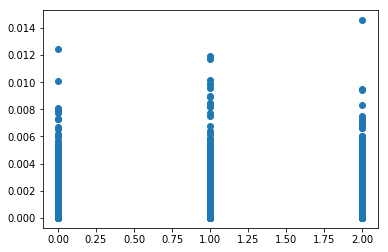

In [81]:
plt.plot(p1.z,p1.p_sz,'o')

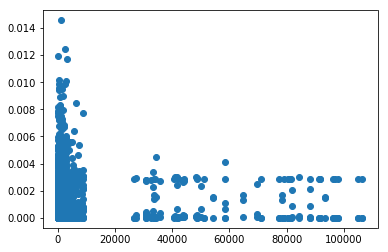

In [75]:
plt.plot(p1.s,p1.p_sz,'o')

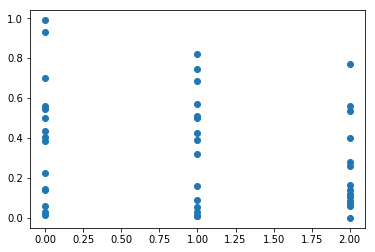

In [76]:
plt.plot(p2.z,p2.p_zu,'o')

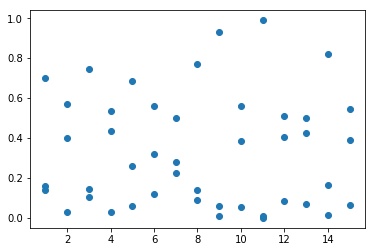

In [77]:
plt.plot(p2.u,p2.p_zu,'o')

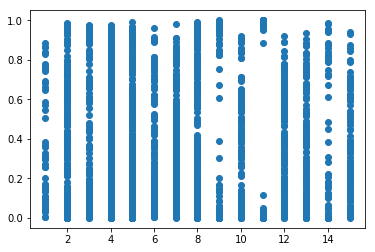

In [78]:
plt.plot(q.u,q.q_zsu,'o')

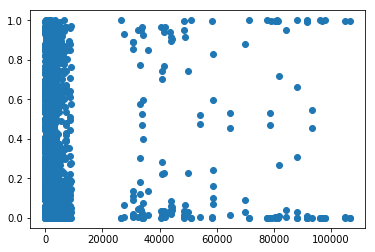

In [79]:
plt.plot(q.s,q.q_zsu,'o')

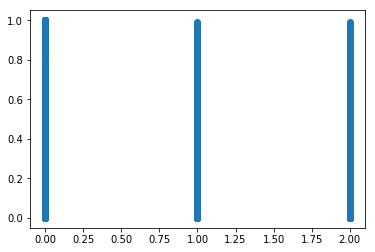

In [80]:
plt.plot(q.z,q.q_zsu,'o')